In [1]:
%load_ext autoreload
%autoreload 2
  
from pprint import pprint
import numpy as np
import torch as th
import torch.autograd as tha


import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')


In [2]:
th.ones(2, 3)


 1  1  1
 1  1  1
[torch.FloatTensor of size 2x3]

In [3]:
a = th.Tensor([[1, 2],[3, 4]])
a


 1  2
 3  4
[torch.FloatTensor of size 2x2]

In [4]:
a_gpu = a.cuda()
print(a_gpu)
a_cpu = a_gpu.cpu()
print(a_cpu)


 1  2
 3  4
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]


 1  2
 3  4
[torch.FloatTensor of size 2x2]



In [5]:
a.view(1, -1)


 1  2  3  4
[torch.FloatTensor of size 1x4]

In [6]:
print(a.mean(dim=0))
print(a.std(dim=1))


 2
 3
[torch.FloatTensor of size 2]


 0.7071
 0.7071
[torch.FloatTensor of size 2]



In [7]:
from torch import autograd as tha
tha.Variable

torch.autograd.variable.Variable

In [8]:
a = tha.Variable(th.ones(2, 3), requires_grad=True)
print(a.data)
print(a.grad)



 1  1  1
 1  1  1
[torch.FloatTensor of size 2x3]

None


In [9]:
x = tha.Variable(th.ones(2), requires_grad=True)
y = 5 * (x + 2) ** 2

o = (1 / 2) * th.sum(y)
o.backward()

x.grad

Variable containing:
 15
 15
[torch.FloatTensor of size 2]

In [4]:
import collections
import gym
import pandas as pd
import roboschool

pd.set_option('display.expand_frame_repr', False)

env_spec_list = gym.envs.registry.all()
envs = collections.defaultdict(list)
envs_df = pd.DataFrame(columns=['name', 'obs_space', 'ac_space', 'obs_range', 'ac_range'])
for i, env_spec in enumerate(env_spec_list):
  try:
    env = env_spec.make()
    obs_space = env.observation_space
    ac_space = env.action_space
    obs_range, ac_range = None, None
    if isinstance(obs_space, gym.spaces.Box):
      obs_range = f'{obs_space.low}:{obs_space.high}'
    if isinstance(ac_space, gym.spaces.Box):
      ac_range = f'{ac_space.low}:{ac_space.high}'
    
    cols = [env_spec.id, obs_space, ac_space, obs_range, ac_range]
    cols_str = [str(c) for c in cols]
    cols_str = [s.replace('Discrete', 'D').replace('Box', 'C').replace('Tuple', 'T')
                for s in cols_str]
    envs_df.loc[i] = cols_str
  
  except gym.error.DependencyNotInstalled:
    envs['deps_not_installed'].append(env_spec)
  except ModuleNotFoundError:
    envs['module_not_found'].append(env_spec)

print(envs_df[['name', 'obs_space', 'ac_space', 'obs_range']])


                                     name                                obs_space                                    ac_space                                          obs_range
0                                 Copy-v0                                     D(6)                         T(D(2), D(2), D(5))                                               None
1                           RepeatCopy-v0                                     D(6)                         T(D(2), D(2), D(5))                                               None
2                     ReversedAddition-v0                                     D(4)                         T(D(4), D(2), D(3))                                               None
3                    ReversedAddition3-v0                                     D(4)                         T(D(4), D(2), D(3))                                               None
4                      DuplicatedInput-v0                                     D(6)                         T(D

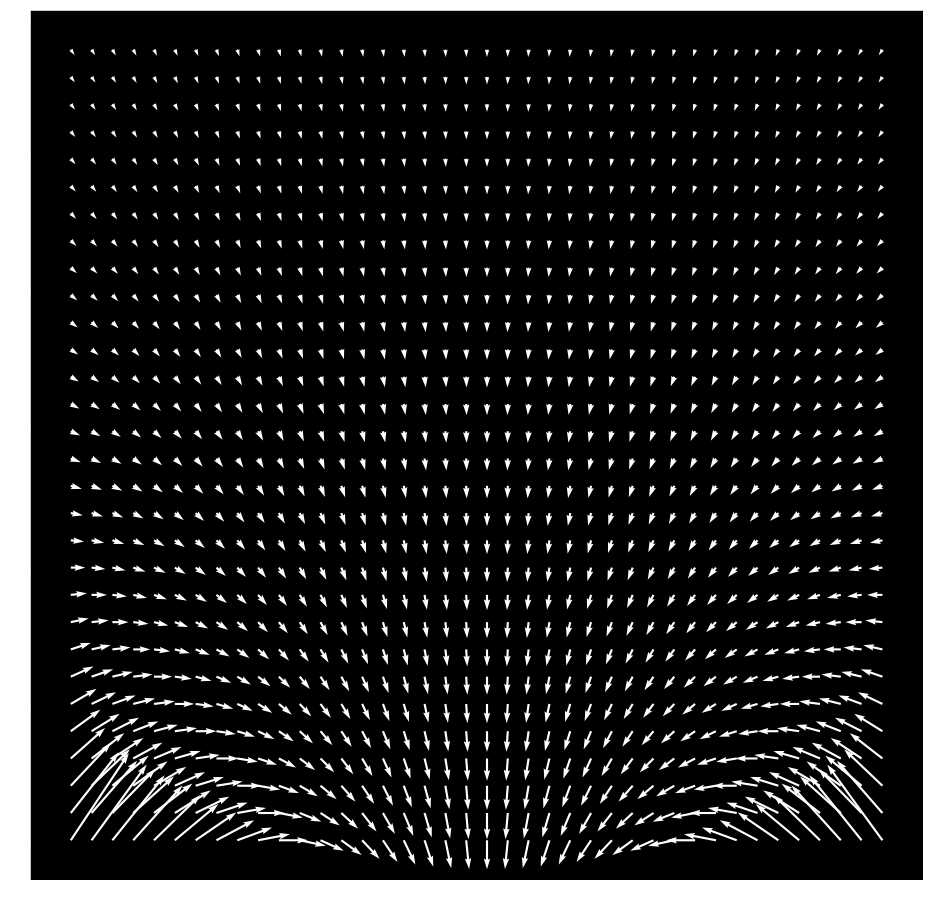

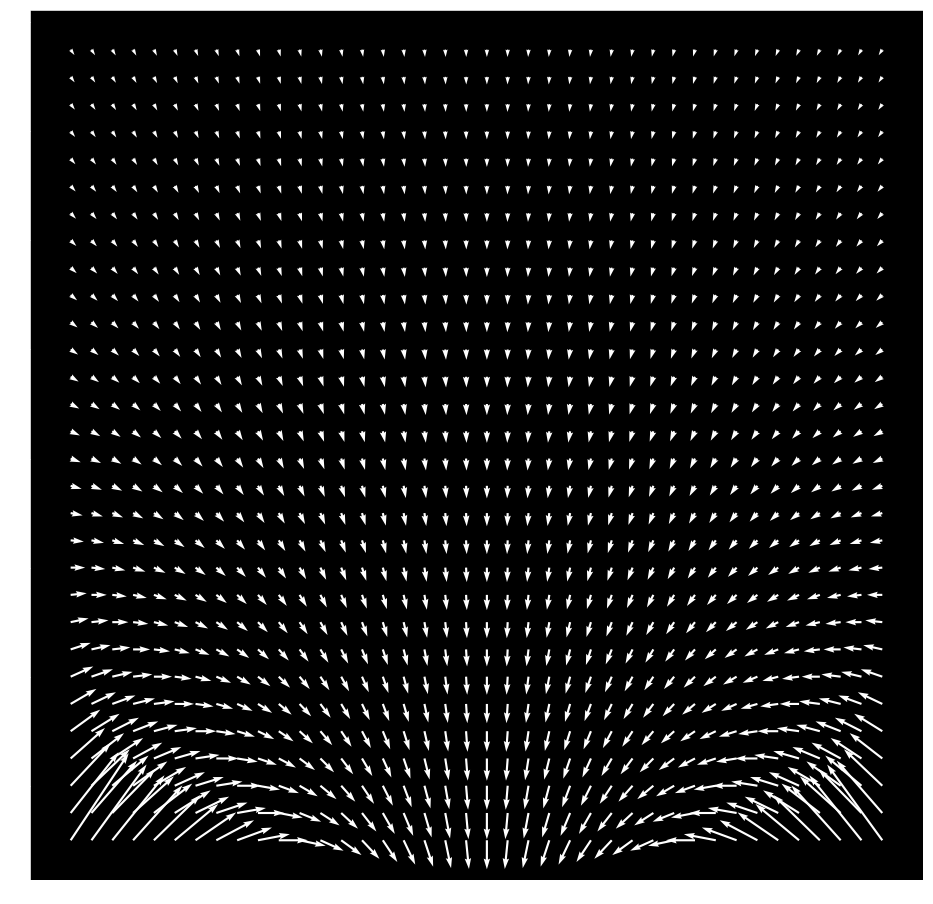

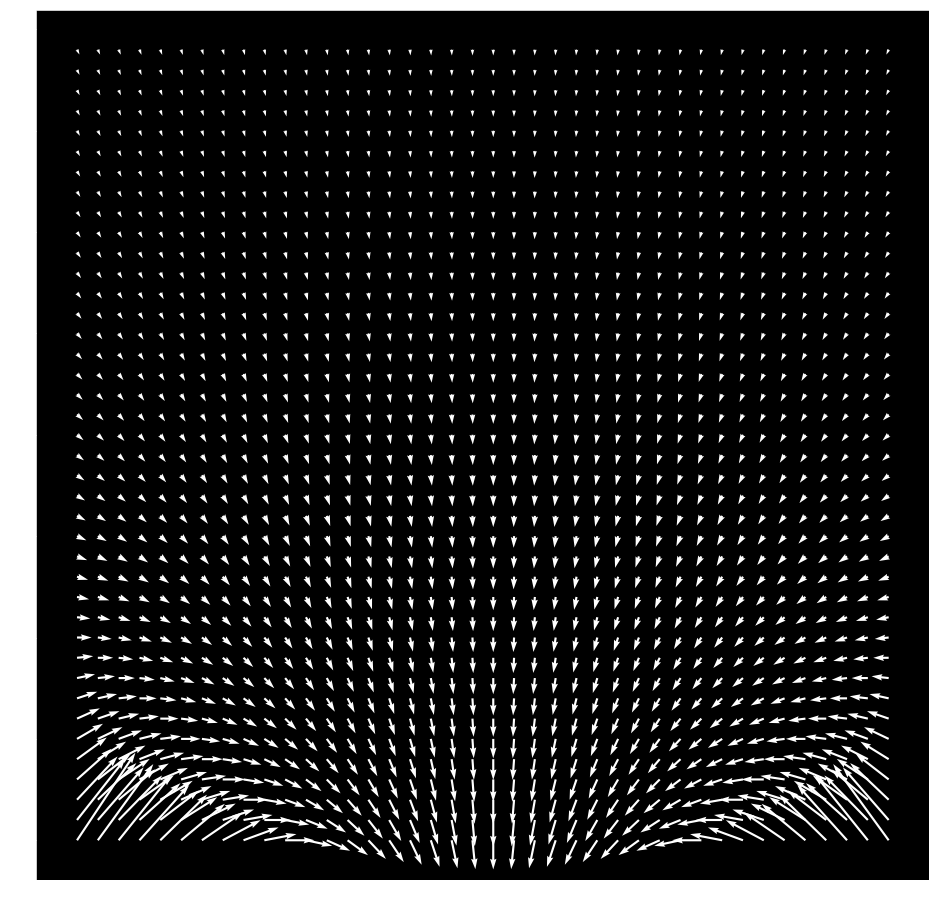

In [3]:
# Testing backprop through torch.distributions.Normal

def to_var(ary, requires_grad=True):
  return tha.Variable(th.Tensor(ary),
                      requires_grad=requires_grad)
def visualize_grads(mean_width, std_width):
  increment = mean_width / 20
  m_range = np.arange(-mean_width, mean_width, increment)
  s_range = np.arange(mean_width / 2, std_width, increment)
  means, stds = np.meshgrid(m_range, s_range)
  grad_means = []
  grad_stds = []
  for s in s_range:
    grad_means.append([])
    grad_stds.append([])
    for m in m_range:
      mean, std = to_var([m]), to_var([s])
      d = th.distributions.Normal(mean, std)
      log_prob = d.log_prob(to_var([0.0], False))
      loss = log_prob  # try exp here!
      loss.backward()
      grad_means[-1].append(mean.grad.data.numpy()[0])
      grad_stds[-1].append(std.grad.data.numpy()[0])
  grad_means = np.array(grad_means)
  grad_stds = np.array(grad_stds)
  pyplot.ion()
  pyplot.figure(figsize=(16, 16))
  pyplot.quiver(means, stds, grad_means, grad_stds, color='w')

visualize_grads(2, 4)
visualize_grads(0.5, 1)
visualize_grads(0.2, 0.5)



In [4]:
def test_torch_normal_sample():
  mean = to_var([0.0])
  std = to_var([1.0])
  d = th.distributions.Normal(mean, std)
  real = d.sample()
  loss = th.abs(10 - real) # does not work
  loss.backward()
  print('torch.distributions.Normal sample')
  print(f'mean grad: {mean.grad}')
  print(f'std grad: {std.grad}')
#test_torch_normal_sample()

def test_torch_normal_logprob():
  mean = to_var([0.0])
  std = to_var([1.0])
  d = th.distributions.Normal(mean, std)
  log_prob = d.log_prob(to_var([10.0], False))
  loss = log_prob
  loss.backward()
  print('torch.distributions.Normal logprob')
  print(f'mean grad: {mean.grad}')
  print(f'std grad: {std.grad}')
test_torch_normal_logprob()



def test_torch_randn():
  mean = to_var([0.0])
  std = to_var([1.0])
  d = th.distributions.Normal(to_var([0.0], False),
                              to_var([1.0], False))
  sampled = d.sample()
  real = sampled * std + mean
  #log_prob = d.log_prob(sampled)
  loss = -th.abs(10 - real)
  loss.backward()
  print('reparameterization.')
  print(mean.grad)
  print(std.grad)
test_torch_randn()


torch.distributions.Normal logprob
mean grad: Variable containing:
 10
[torch.FloatTensor of size 1]

std grad: Variable containing:
 99
[torch.FloatTensor of size 1]

reparameterization.
Variable containing:
 1
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  9.7049
[torch.FloatTensor of size 1]



In [6]:
# Test plotter.top_k()

from rl.algs import plotter

def test_top_k():
  plt = plotter.Plotter()
  plt.add_data('a', 5, -1)
  plt.add_data('a', 10, 3)
  plt.add_data('a', 15, 6)
  plt.add_data('a', 20, 5)
  
  print(plt.top_k('a', k=3))

test_top_k()


(array([15, 20, 10]), array([6, 5, 3]))
